In [1]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, root, least_squares
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import CubicSpline

In [2]:
def integrate_one_cycle(sim):
    time_step = 0.2
    bisection_tol=1e-11
    target_mean_anomaly = 4*np.pi
    current_mean_anomaly = 0
    N_peri = 0
    counter = 0
    M = [0]
    times = [sim.t]
    
    while True:
        # Integrate by stepping one time
        time_now = sim.t + time_step
        sim.integrate(time_now)
        
        # Getting the actual current mean anomaly
        current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi

        # Correct mean anomaly
        if current_mean_anomaly - M[-1] < 0:
            N_peri += 1
            current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi 
            M.append(current_mean_anomaly)
            # print(f"Starting {N_peri}")
        else:
            M.append(current_mean_anomaly)

        # Store time
        times.append(sim.t)

        # Find the precise 16pi
        if current_mean_anomaly > target_mean_anomaly:
            target_time = bisection_sin_M(sim, target_mean_anomaly, times[-2], times[-1], M[-2], M[-1], tol=bisection_tol)
            sim.integrate(target_time)
            return sim, target_time, times, M
            # return M, times, target_time


def bisection_sin_M(sim, target, a, b, Ma, Mb, tol=1e-9, doom_counts=10000):
    """
    Bisection method on sin M. The function terminates after a certain attempt.
    """    
    func = CubicSpline([a, b], [Ma, Mb], bc_type='natural')

    while True:
        half = (a + b)/2
        
        # If the target lies on the first half
        if (func(half) - target) > 0:
            a = a
            b = half
    
        # If the target lies on the second half
        if (func(half) - target) < 0:
            a = half
            b = b
    
        # print(np.abs(fa - fb))
        
        if np.abs(a - b) < tol:
            # print(half, func(half))
            break

    return half

def wrap_angles(angles):
    for i, ang in enumerate(angles):
        while ang > np.pi or ang <= -np.pi:
            if ang < 0:
                ang += 2*np.pi
            elif ang > 0:
                ang -= 2*np.pi

        angles[i] = ang

    return angles

def wrap_angle(ang):
    while ang > np.pi or ang <= -np.pi:
        if ang < 0:
            ang += 2*np.pi
        elif ang > 0:
            ang -= 2*np.pi
    
    return ang

In [3]:
def init_simulation(theta, configs):
    inner_period = 2*np.pi
    
    init_e = 10 ** np.array(theta[0:2], dtype=np.float64)
    init_M = theta[2]
    init_pomega = -theta[3]
    
    sim = rebound.Simulation()

    sim.add(m=1)
    sim.add(m=1e-7, P=inner_period, e=init_e[0])
    sim.add(m=1e-7, P=inner_period*2., pomega=init_pomega, M=init_M, e=init_e[1])
    
    return sim


def optimizing_function(theta):
    init_theta = theta
    # print('a')
    init_sim = init_simulation(init_theta, None)
    # print('b')
    

    final_sim, target_time, _, _ = integrate_one_cycle(init_sim)
    final_sim.move_to_hel()
    # print('c')
    

    final_theta = np.log10(final_sim.particles[1].e), np.log10(final_sim.particles[2].e), wrap_angle(final_sim.particles[2].M), wrap_angle(final_sim.particles[1].pomega - final_sim.particles[2].pomega)

    theta_diff = np.asarray(final_theta) - np.asarray(init_theta)
    print(init_theta, final_theta)
    print(theta_diff)

    diff = np.sum(theta_diff ** 2)
    print(diff)
    return diff

    # return theta_diff

In [4]:
# res = minimize(optimizing_function, x0=init_theta, method='Nelder-Mead')

init_theta = [-1, -1, 0, 0]

bounds = [(-3, -0.5), (-3, -0.5), (-np.pi, np.pi), (-np.pi, np.pi)]

res_0 = minimize(optimizing_function, x0=init_theta, method='Nelder-Mead', bounds=bounds, options={ 'xatol':1e-14, 'fatol':1e-14})
res = minimize(optimizing_function, x0=res_0.x, method='L-BFGS-B', bounds=bounds, tol=1e-16)
# res = minimize(optimizing_function, x0=res.x, method='Nelder-Mead', bounds=bounds)
# res = root(optimizing_function, x0=init_theta)

[-1. -1.  0.  0.] (np.float64(-1.0000000000123002), np.float64(-0.999999999970309), -1.4894533919118658e-05, -1.5081952186024557e-05)
[-1.23001609e-11  2.96910274e-11 -1.48945339e-05 -1.50819522e-05]
4.4931242241034e-10
[-1.05 -1.    0.    0.  ] (np.float64(-1.0500000000128236), np.float64(-0.9999999999645743), -1.6484591262688753e-05, -1.7390300600903274e-05)
[-1.28235200e-11  3.54256624e-11 -1.64845913e-05 -1.73903006e-05]
5.741643040891106e-10
[-1.   -1.05  0.    0.  ] (np.float64(-1.000000000008655), np.float64(-1.0499999999741199), -1.398348844805497e-05, -1.431024531632042e-05)
[-8.65507666e-12  2.58801869e-11 -1.39834884e-05 -1.43102453e-05]
4.00321070190902e-10
[-1.0e+00 -1.0e+00  2.5e-04  0.0e+00] (np.float64(-0.9999999973405338), np.float64(-1.0000000012862893), 0.00023510484464939196, -1.508194163355109e-05)
[ 2.65946620e-09 -1.28628930e-09 -1.48951554e-05 -1.50819416e-05]
4.493306250838898e-10
[-1.0e+00 -1.0e+00  0.0e+00  2.5e-04] (np.float64(-1.0000000022431514), np.float6

In [5]:
res_0

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.8336393734278735e-18
             x: [-8.098e-01 -1.798e+00  1.458e-02  1.575e-02]
           nit: 342
          nfev: 681
 final_simplex: (array([[-8.098e-01, -1.798e+00,  1.458e-02,  1.575e-02],
                       [-8.098e-01, -1.798e+00,  1.458e-02,  1.575e-02],
                       ...,
                       [-8.098e-01, -1.798e+00,  1.458e-02,  1.575e-02],
                       [-8.098e-01, -1.798e+00,  1.458e-02,  1.575e-02]]), array([ 4.834e-18,  4.834e-18,  4.834e-18,  4.834e-18,
                        4.834e-18]))

In [6]:
res

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 4.8336393734278735e-18
        x: [-8.098e-01 -1.798e+00  1.458e-02  1.575e-02]
      nit: 0
      jac: [ 1.618e-15  1.848e-15  2.346e-15  8.632e-16]
     nfev: 75
     njev: 15
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

12.566364372632217
-0.0003836439840474971


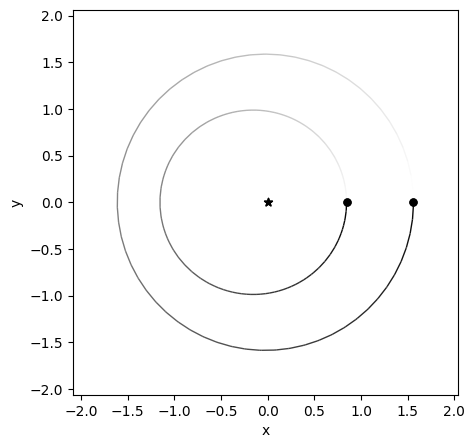

In [7]:

sim = init_simulation(res.x, None)
_, target_time, times, M = integrate_one_cycle(sim)
print(target_time)
sim.integrate(target_time*100)
print(sim.particles[1].pomega)
rebound.OrbitPlot(sim)


In [8]:
marks = np.arange(0, 5001, 1)

print(target_time)

sim = init_simulation(res.x, None)
_, target_time, _, _ = integrate_one_cycle(sim)

angle_hist = np.zeros(len(marks))
pomega_1_hist = np.zeros(len(marks))
pomega_2_hist = np.zeros(len(marks))


for i, m in enumerate(marks):
    sim.integrate(sim.t + target_time)
    sim.t = 0
    sim.move_to_hel()
    
    angle_hist[i] = sim.particles[1].l - 2*sim.particles[2].l + sim.particles[1].pomega

    pomega_1_hist[i] = sim.particles[1].pomega
    pomega_2_hist[i] = sim.particles[2].pomega

    # print(sim.particles[1].l, sim.particles[2].l, sim.particles[1].pomega)

12.566364372632217


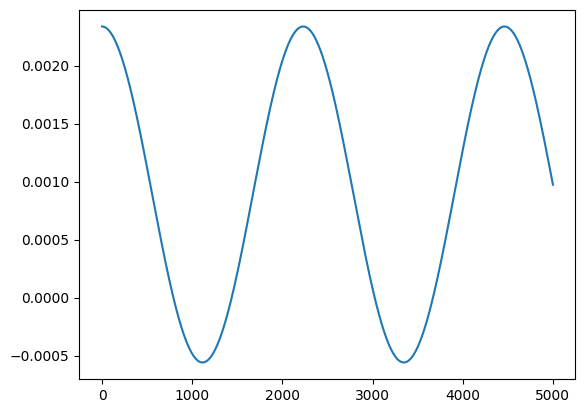

In [9]:
plt.plot(wrap_angles(angle_hist))

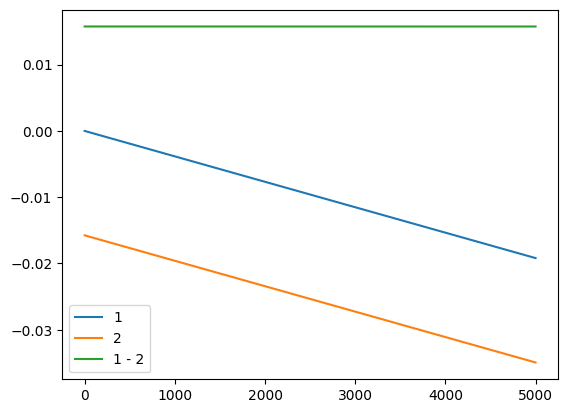

In [10]:
plt.plot(wrap_angles(pomega_1_hist), label='1')
plt.plot(wrap_angles(pomega_2_hist), label='2')
plt.plot(wrap_angles(pomega_1_hist - pomega_2_hist), label='1 - 2')
plt.legend()